# Section 0.a: Setup

In [216]:
# Package imports
import matplotlib.pyplot as plt
import pandas as pd
import ast
import numpy as np
import sqlite3

In [217]:
# Constants
DB_PATH = '../data/2024.sqlite3'

ALL_CLUBS_DESC = ['D', '3W', '3H', '4H', '5', '6', '7', '8', '9', 'P', '50°', '56°', '62°']
ALL_CLUBS_ASC = ['62°', '56°', '50°', 'P', '9', '8', '7', '6', '5', '4H', '3H', '3W', 'D']
CLUBS_DESC = ['D', '3W', '3H', '4H', '5', '6', '7', '8', '9', 'P']
CLUBS_ASC = ['P', '9', '8', '7', '6', '5', '4H', '3H', '3W', 'D']
WEDGES_DESC = ['50°', '56°', '62°']
WEDGES_ASC = ['62°', '56°', '50°']

SCATTER_COLORS = [
    "#FF5733",  # Vibrant Orange  
    "#33A1FD",  # Bright Blue  
    "#28A745",  # Fresh Green  
    "#FFC300",  # Bold Yellow  
    "#C70039",  # Deep Red  
    "#900C3F",  # Dark Magenta  
    "#581845",  # Rich Purple  
    "#2ECC71",  # Lively Lime  
    "#F39C12",  # Bright Gold  
    "#1ABC9C",  # Tropical Teal  
]

In [218]:
# Load all data.
connection = sqlite3.connect(DB_PATH)
courses_df = pd.read_sql('SELECT * FROM course_course', connection)
holes_df = pd.read_sql('SELECT * FROM course_hole', connection)
tees_df = pd.read_sql('SELECT * FROM course_tee', connection)

rounds_df = pd.read_sql('SELECT * FROM round_round', connection)
holestats_df = pd.read_sql('SELECT * FROM round_holestats', connection)
strokes_df = pd.read_sql('SELECT * FROM round_stroke', connection)
putts_df = pd.read_sql('SELECT * FROM round_putt', connection)
connection.close()

# Data overview
print(f'''Data Overview
// Course Data
/ Courses: {len(courses_df)}
/ Tees: {len(tees_df)}
/ Holes: {len(holes_df)}
// Round Data
/ Rounds Recorded (Total): {len(rounds_df)}
/ Rounds Recorded (2024): {len(rounds_df.loc[(rounds_df['date_played'] >= '2024-01-01') & (rounds_df['date_played'] <= '2024-12-31')])}
/ Strokes Recorded: {len(strokes_df)}
/ Putts Recorded: {len(putts_df)}
/ % of Strokes Recorded Were Putts: {(len(putts_df) / (len(putts_df) + len(strokes_df)) * 100):.2f}%
/ Average Score Per Round: {(len(putts_df) + len(strokes_df)) / len(rounds_df)}
''')

Data Overview
// Course Data
/ Courses: 14
/ Tees: 36
/ Holes: 234
// Round Data
/ Rounds Recorded (Total): 32
/ Rounds Recorded (2024): 32
/ Strokes Recorded: 1540
/ Putts Recorded: 940
/ % of Strokes Recorded Were Putts: 37.90%
/ Average Score Per Round: 77.5



In [219]:
# Define local helper functions
import math

def degrees_to_radians(degrees):
    return degrees * (math.pi / 180.0)

def meters_to_yards(meters):
    return meters * 1.09361

def get_distance_between_points_meters(lat1, long1, lat2, long2):
    earth_radius_km = 6371
    deg_lat = degrees_to_radians(lat2 - lat1)
    deg_long = degrees_to_radians(long2 - long1)
    a = math.sin(deg_lat / 2) * math.sin(deg_lat / 2) + math.cos(degrees_to_radians(lat1)) * math.cos(degrees_to_radians(lat2)) * math.sin(deg_long / 2) * math.sin(deg_long / 2)
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    dist_km = earth_radius_km * c
    dist_m = dist_km * 1000
    return dist_m

def get_distance_between_points_yards(lat1, long1, lat2, long2):
    dist_m = get_distance_between_points_meters(lat1, long1, lat2, long2)
    dist_yards = meters_to_yards(dist_m)
    return dist_yards

In [220]:
# More helper functions
def parse_coordinates(coord_str):
    if pd.isnull(coord_str):
        return None  # Return None if the coordinate is null
    return ast.literal_eval(coord_str)

def parse_coordinates_with_parentheses(coord_str):
    if pd.isnull(coord_str):
        return None  # Return None if the coordinate is null
    return ast.literal_eval(coord_str[1:-1])

def distance_from_coords(row):
    if row['start_coordinate'] is None or row['end_coordinate'] is None:
        return 0
    
    return get_distance_between_points_yards(
        row['start_coordinate'][0], row['start_coordinate'][1],
        row['end_coordinate'][0], row['end_coordinate'][1]
    )

In [289]:
# Build additional stroke columns
def fill_penalty_result(row):
    row_rnd_id = row['rnd_id']
    row_hole_id = row['hole_id']
    row_stroke_num = row['stroke_number']
    if not strokes_df.loc[(strokes_df['rnd_id'] == row_rnd_id) &\
        (strokes_df['hole_id'] == row_hole_id) &\
        (strokes_df['stroke_number'] == row_stroke_num + 1) &\
        (strokes_df['penalty'])].empty:
        return True
    return False
    
def fill_green_hit_result(row):
    row_rnd_id = row['rnd_id']
    row_hole_id = row['hole_id']
    row_stroke_num = row['stroke_number']
    if strokes_df.loc[(strokes_df['rnd_id'] == row_rnd_id) &\
        (strokes_df['hole_id'] == row_hole_id) &\
        (strokes_df['stroke_number'] == row_stroke_num + 1)].empty:
        return True
    return False

def fill_next_putt(row):
    if row['hit_green']:
        putt_distances_for_hole = putts_df[(putts_df['rnd_id'] == row['rnd_id']) & \
            (putts_df['hole_id'] == row['hole_id']) & \
            (putts_df['stroke_number'] == row['stroke_number'] + 1)]['distance']
        if not putt_distances_for_hole.empty:
            return putt_distances_for_hole.iloc[0]
        else:
            return np.nan
    else:
        return np.nan
strokes_df['penalty_result'] = strokes_df.apply(fill_penalty_result, axis=1)
strokes_df['hit_green'] = strokes_df.apply(fill_green_hit_result, axis=1)
strokes_df['hit_green_putt_dist'] = strokes_df.apply(fill_next_putt, axis=1)

# Section 1: Scoring Statistics

In [222]:
def get_round_full_shots(row):
    return len(strokes_df[strokes_df['rnd_id'] == row['id']])

def get_round_putts(row):
    return len(putts_df[putts_df['rnd_id'] == row['id']])

In [223]:
# Rounds played for year summary
rounds_df['num_full_shots'] = rounds_df.apply(get_round_full_shots, axis=1)
rounds_df['num_putts'] = rounds_df.apply(get_round_putts, axis=1)
rounds_df['total_score'] = rounds_df['num_full_shots'] + rounds_df['num_putts']

In [224]:
# Filter rounds - we only want full rounds, score > 80
rounds_df = rounds_df[rounds_df['total_score'] > 80]
rounds_df = rounds_df.merge(courses_df, how='inner', left_on='course_id', right_on='id')

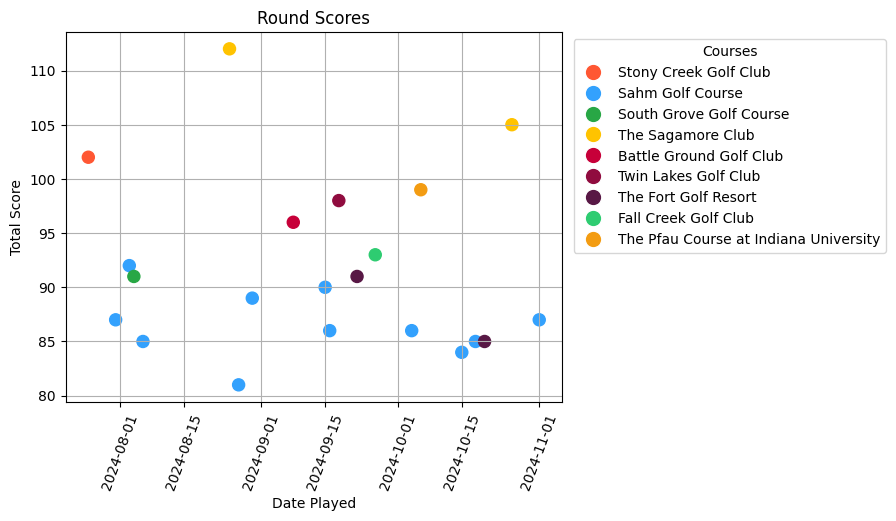

In [225]:
# Assume rounds['course_id'] exists in your DataFrame
course_ids = rounds_df['name'].unique()

# Create a dictionary to map course_ids to colors
course_color_map = {course_id: SCATTER_COLORS[i % len(SCATTER_COLORS)] for i, course_id in enumerate(course_ids)}

# Map colors to rounds based on course_id
rounds_df['color'] = rounds_df['name'].map(course_color_map)

# Prepare data for scatter plot
dates = [pd.to_datetime(d) for d in rounds_df['date_played']]
scatter_colors = rounds_df['color']  # Colors mapped to course_id

# Create the scatter plot
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

legend_elements = [
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=12, label=course_id)
    for course_id, color in course_color_map.items()
]
ax.legend(handles=legend_elements, title="Courses", bbox_to_anchor=(1.01, 1))

ax.scatter(dates, rounds_df['total_score'], s=75, color=scatter_colors)
ax.tick_params(axis='x', labelrotation=70)
ax.grid(True)
ax.set_title('Round Scores')
ax.set_xlabel('Date Played')
ax.set_ylabel('Total Score')
plt.show()

,id_x,date_played,course_id_x,played_tee_id,finish_time,group_makeup,holes_completed,mobility,notes,round_counts_toward_hci,...,image_url,num_holes,color_x,id,color_y,name_y,yardage,rating,course_id_y,slope
1,16.0,2024-07-31,1.0,2.0,9:20pm,Randoms,18.0,Walking,None,0.0,...,https://sahmgolf.com/wp-content/uploads/2019/0...,18.0,#33A1FD,2,ffffff,Men's,6061,68.4,1,110.0
2,18.0,2024-08-03,1.0,2.0,None,Mixed,18.0,Walking,Good round w/ Jacob. That 9 on 10 really threw...,0.0,...,https://sahmgolf.com/wp-content/uploads/2019/0...,18.0,#33A1FD,2,ffffff,Men's,6061,68.4,1,110.0
3,26.0,2024-08-06,1.0,2.0,None,Mixed,18.0,Walking,None,0.0,...,https://sahmgolf.com/wp-content/uploads/2019/0...,18.0,#33A1FD,2,ffffff,Men's,6061,68.4,1,110.0
4,31.0,2024-08-27,1.0,2.0,8:30,Friends,18.0,Carting,All time best 81! Played with Joel Van Auken f...,0.0,...,https://sahmgolf.com/wp-content/uploads/2019/0...,18.0,#33A1FD,2,ffffff,Men's,6061,68.4,1,110.0
5,32.0,2024-08-30,1.0,2.0,5:00pm,Randoms,18.0,Pushing,"Slow round, felt like I was just barely hangin...",0.0,...,https://sahmgolf.com/wp-content/uploads/2019/0...,18.0,#33A1FD,2,ffffff,Men's,6061,68.4,1,110.0


Slope/Score Correlation: [[1.         0.65520759]
 [0.65520759 1.        ]]
Rating/Score Correlation: [[1.         0.32030555]
 [0.32030555 1.        ]]


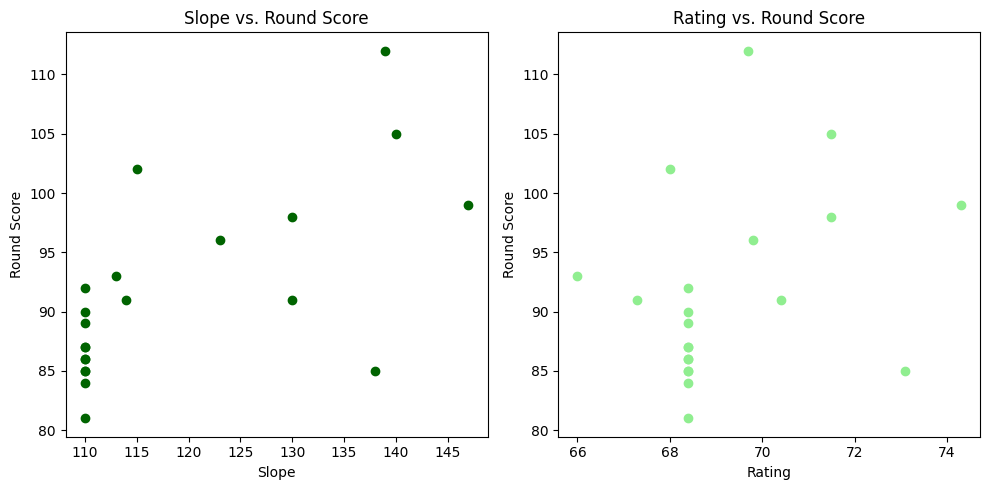

In [226]:
rounds_tees_df = rounds_df.merge(tees_df, how='right', left_on='played_tee_id', right_on='id')
rounds_tees_df = rounds_tees_df[(~rounds_tees_df['id'].isna()) & (~rounds_tees_df['id_x'].isna())]
fix, axs = plt.subplots(1, 2, figsize=(10, 5), tight_layout=True)
axs[0].scatter(rounds_tees_df['slope'], rounds_tees_df['total_score'], color='darkgreen')
axs[0].set_xlabel('Slope')
axs[0].set_ylabel('Round Score')
axs[0].set_title('Slope vs. Round Score')

axs[1].scatter(rounds_tees_df['rating'], rounds_tees_df['total_score'], color='lightgreen')
axs[1].set_xlabel('Rating')
axs[1].set_ylabel('Round Score')
axs[1].set_title('Rating vs. Round Score')

display(rounds_tees_df.head())
r_slope = np.corrcoef(rounds_tees_df['slope'], rounds_tees_df['total_score'])
r_rating = np.corrcoef(rounds_tees_df['rating'], rounds_tees_df['total_score'])

print(f'Slope/Score Correlation: {r_slope}')
print(f'Rating/Score Correlation: {r_rating}')

In [227]:
# Round Stats Overview
def find_gir_for_round(row):
    return len(holestats_df[(holestats_df['rnd_id'] == row['id_x']) & (holestats_df['gir'] == True)])

def find_gld_for_round(row):
    return len(holestats_df[(holestats_df['rnd_id'] == row['id_x']) & (holestats_df['gld'] == True)])

def find_scr_for_round(row):
    return len(holestats_df[(holestats_df['rnd_id'] == row['id_x']) & (holestats_df['scrambling'] == 1)])

rounds_df['num_gir'] = rounds_df.apply(find_gir_for_round, axis=1)
rounds_df['num_gld'] = rounds_df.apply(find_gld_for_round, axis=1)
rounds_df['num_scr'] = rounds_df.apply(find_scr_for_round, axis=1)
average_gir_per_round = rounds_df['num_gir'].mean()
average_gld_per_round = rounds_df['num_gld'].mean()
average_scr_per_round = rounds_df['num_scr'].mean()
print(f'Average GIR per round: {average_gir_per_round:.2f}')
print(f'Average GLD per round: {average_gld_per_round:.2f}')
print(f'Average SCR per round: {average_scr_per_round:.2f}')
print(f'Average # Putts per round: {rounds_df['num_putts'].mean():.2f}')
print(f'Average Score per round: {rounds_df['total_score'].mean():.2f}')

Average GIR per round: 4.48
Average GLD per round: 7.24
Average SCR per round: 1.48
Average # Putts per round: 34.57
Average Score per round: 91.62


In [306]:
# Stats By Course
mean_rounds_by_course = rounds_by_course.groupby('name_y')[['total_score', 'num_putts', 'num_gld', 'num_gir', 'num_scr']].mean() \
    .reset_index() \
    .rename(columns={
        'name_y': 'Course', 
        'total_score': 'Ave. Score', 
        'num_putts': 'Ave. Putts', 
        'num_gld': 'Ave. GLD', 
        'num_gir': 'Ave. GIR', 
        'num_scr': 'Ave. Up & Down'
    })

median_rounds_by_course = rounds_by_course.groupby('name_y')[['total_score', 'num_putts', 'num_gld', 'num_gir', 'num_scr']].median() \
    .reset_index() \
    .rename(columns={
        'name_y': 'Course', 
        'total_score': 'Med. Score', 
        'num_putts': 'Med. Putts', 
        'num_gld': 'Med. GLD', 
        'num_gir': 'Med. GIR', 
        'num_scr': 'Med. Up & Down'
    })

std_rounds_by_course = rounds_by_course.groupby('name_y')[['total_score', 'num_putts', 'num_gld', 'num_gir', 'num_scr']].std() \
    .dropna() \
    .reset_index() \
    .rename(columns={
        'name_y': 'Course', 
        'total_score': 'SD Score', 
        'num_putts': 'SD Putting', 
        'num_gld': 'SD GLD', 
        'num_gir': 'SD GIR', 
        'num_scr': 'SD Up & Down'
    })

display(mean_rounds_by_course)
display(median_rounds_by_course)
display(std_rounds_by_course)

,Course,Ave. Score,Ave. Putts,Ave. GLD,Ave. GIR,Ave. Up & Down
0,Battle Ground Golf Club,96.000000,38.000000,9.000000,3.000000,1.000000
1,Fall Creek Golf Club,93.000000,31.000000,7.000000,2.000000,2.000000
2,Sahm Golf Course,86.545455,34.636364,8.090909,5.454545,1.818182
3,South Grove Golf Course,91.000000,31.000000,4.000000,3.000000,2.000000
4,Stony Creek Golf Club,102.000000,37.000000,3.000000,4.000000,0.000000
5,The Fort Golf Resort,88.000000,33.500000,6.000000,5.500000,1.500000
6,The Pfau Course at Indiana University,99.000000,40.000000,7.000000,6.000000,0.000000
7,The Sagamore Club,108.500000,33.000000,8.500000,0.500000,1.500000
8,Twin Lakes Golf Club,98.000000,35.000000,4.000000,4.000000,0.000000


,Course,Med. Score,Med. Putts,Med. GLD,Med. GIR,Med. Up & Down
0,Battle Ground Golf Club,96.0,38.0,9.0,3.0,1.0
1,Fall Creek Golf Club,93.0,31.0,7.0,2.0,2.0
2,Sahm Golf Course,86.0,34.0,8.0,5.0,2.0
3,South Grove Golf Course,91.0,31.0,4.0,3.0,2.0
4,Stony Creek Golf Club,102.0,37.0,3.0,4.0,0.0
5,The Fort Golf Resort,88.0,33.5,6.0,5.5,1.5
6,The Pfau Course at Indiana University,99.0,40.0,7.0,6.0,0.0
7,The Sagamore Club,108.5,33.0,8.5,0.5,1.5
8,Twin Lakes Golf Club,98.0,35.0,4.0,4.0,0.0


,Course,SD Score,SD Putting,SD GLD,SD GIR,SD Up & Down
0,Sahm Golf Course,3.012097,2.335497,1.868397,2.067058,0.981650
1,The Fort Golf Resort,4.242641,0.707107,1.414214,0.707107,0.707107
2,The Sagamore Club,4.949747,0.000000,2.121320,0.707107,2.121320


In [315]:
# Group hole stats by par and total round score
def get_score_for_hole(row):
    return len(strokes_df[(strokes_df['rnd_id'] == row['rnd_id']) & (strokes_df['hole_id'] == row['hole_id'])]) + \
        len(putts_df[(putts_df['rnd_id'] == row['rnd_id']) & (putts_df['hole_id'] == row['hole_id'])]) 
    
holestats_scoring = holestats_df.merge(holes_df, how='inner', left_on='hole_id', right_on='id')
holestats_scoring['total_for_played_hole'] = holestats_scoring.apply(get_score_for_hole, axis=1)

scoring_by_par = holestats_scoring.groupby('par')['total_for_played_hole'] 
mean_scores_by_par = scoring_by_par.mean().reset_index().rename(columns={'par': 'Par', 'total_for_played_hole', 'Mean' })
median_scores_by_par = scoring_by_par.median().reset_index()
std_scores_by_par = scoring_by_par.std().reset_index()

overall_scoring_by_par = mean_scores_by_par.merge(median_scores_by_par, on='par') \
    .merge(std_scores_by_par, on='par')
overall_scoring_by_par.head()

SyntaxError: ':' expected after dictionary key (1386437104.py, line 10)

# Section 2: Club Statistics

In [229]:
# Clean data
strokes_df = strokes_df.dropna()
strokes_df = strokes_df[strokes_df['club'] != 'Club'] # Times where we forgot to input club

# Convert coordinates to tuples
strokes_df['start_coordinate'] = strokes_df['start_coordinate'].astype(str).apply(parse_coordinates)
strokes_df['end_coordinate'] = strokes_df['end_coordinate'].astype(str).apply(parse_coordinates)

# Add distance column
strokes_df['distance'] = strokes_df.apply(distance_from_coords, axis=1)

In [230]:
# Build Description DF
mean_distances_by_club = strokes_df.groupby('club')[['distance']].mean().reindex(ALL_CLUBS_ASC).reset_index() \
    .rename(columns={'club': 'Club', 'distance': 'Mean Distance'})

median_distances_by_club = strokes_df.groupby('club')[['distance']].median().reindex(ALL_CLUBS_ASC).reset_index() \
    .rename(columns={'club': 'Club', 'distance': 'Median Distance'})

std_distances_by_club = strokes_df.groupby('club')[['distance']].std().reindex(ALL_CLUBS_ASC).reset_index() \
    .rename(columns={'club': 'Club', 'distance': 'Std. Dev.'})

min_distances_by_club = strokes_df.groupby('club')[['distance']].min().reindex(ALL_CLUBS_ASC).reset_index() \
    .rename(columns={'club': 'Club', 'distance': 'Min'})

max_distances_by_club = strokes_df.groupby('club')[['distance']].max().reindex(ALL_CLUBS_ASC).reset_index() \
    .rename(columns={'club': 'Club', 'distance': 'Max'})

distances_by_club = mean_distances_by_club.merge(median_distances_by_club, on='Club') \
    .merge(std_distances_by_club, on='Club') \
    .merge(min_distances_by_club, on='Club') \
    .merge(max_distances_by_club, on='Club')

# Display the result
display(distances_by_club)

,Club,Mean Distance,Median Distance,Std. Dev.,Min,Max
0,62°,28.683034,26.698780,18.387499,0.252824,79.014872
1,56°,33.737198,23.906938,26.792650,1.031457,129.490469
2,50°,80.492961,90.596142,30.846137,9.703287,141.619374
3,P,90.286767,109.840481,46.588150,13.035304,150.686426
4,9,122.922864,133.243551,35.660082,26.404489,190.887843
5,8,129.904977,135.517331,38.369502,6.045629,228.232278
6,7,132.436406,145.552148,42.734847,6.723636,208.805957
7,6,134.918314,151.977503,50.700757,8.081561,243.894000
8,5,137.923620,156.123877,54.453733,19.428896,220.560562
9,4H,162.609153,182.334512,59.298793,29.169833,253.436610


(np.float64(0.0), np.float64(1.0), np.float64(0.0), np.float64(1.0))

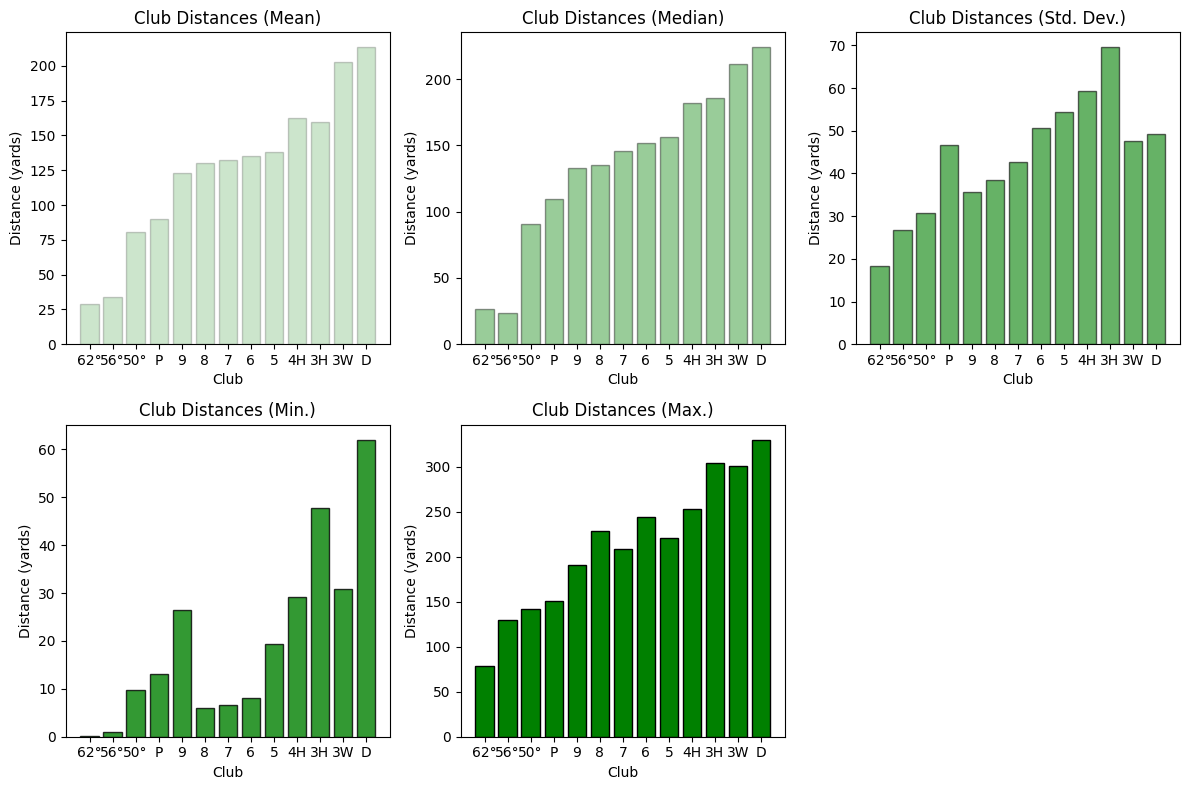

In [231]:
# Visualize Club Descriptions
fig, axs = plt.subplots(2, 3, figsize=(12, 8), tight_layout=True)
axs[0][0].bar(ALL_CLUBS_ASC, distances_by_club['Mean Distance'], color='green', alpha=0.2, edgecolor='black')
axs[0][0].set_title('Club Distances (Mean)')
axs[0][0].set_xlabel('Club')
axs[0][0].set_ylabel('Distance (yards)')

axs[0][1].bar(ALL_CLUBS_ASC, distances_by_club['Median Distance'], color='green', alpha=0.4, edgecolor='black')
axs[0][1].set_title('Club Distances (Median)')
axs[0][1].set_xlabel('Club')
axs[0][1].set_ylabel('Distance (yards)')

axs[0][2].bar(ALL_CLUBS_ASC, distances_by_club['Std. Dev.'], color='green', alpha=0.6, edgecolor='black')
axs[0][2].set_title('Club Distances (Std. Dev.)')
axs[0][2].set_xlabel('Club')
axs[0][2].set_ylabel('Distance (yards)')

axs[1][0].bar(ALL_CLUBS_ASC, distances_by_club['Min'], color='green', alpha=0.8, edgecolor='black')
axs[1][0].set_title('Club Distances (Min.)')
axs[1][0].set_xlabel('Club')
axs[1][0].set_ylabel('Distance (yards)')

axs[1][1].bar(ALL_CLUBS_ASC, distances_by_club['Max'], color='green', alpha=1, edgecolor='black')
axs[1][1].set_title('Club Distances (Max.)')
axs[1][1].set_xlabel('Club')
axs[1][1].set_ylabel('Distance (yards)')

axs[1][2].axis('off')

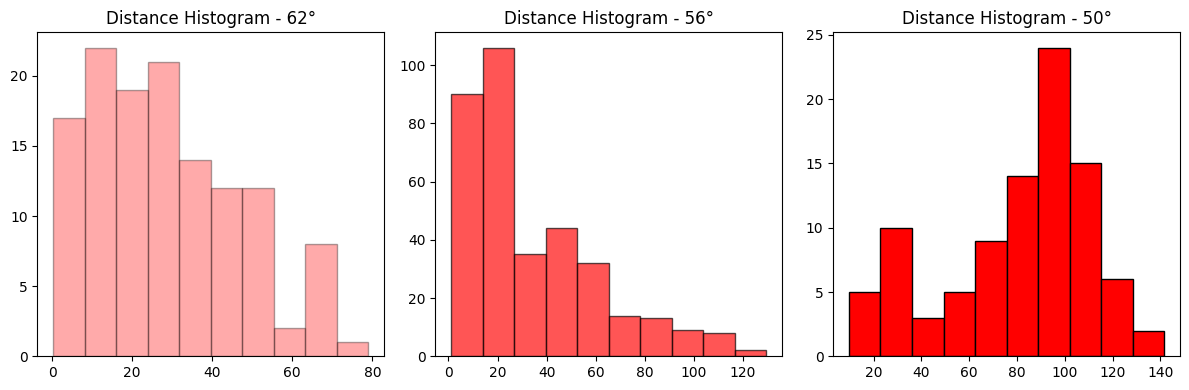

In [232]:
# Plot wedge histograms
fig, axs = plt.subplots(1, 3, figsize=(12, 4), tight_layout=True)
next_alpha = 0
for i, wedge in enumerate(WEDGES_ASC):
    strokes_for_wedge = strokes_df.where(strokes_df['club'] == wedge)
    axs[i].hist(x = strokes_for_wedge[['distance']], edgecolor='black', color='red', bins=10, alpha = (next_alpha := next_alpha + 0.3333))
    axs[i].set_title(f'Distance Histogram - {wedge}')

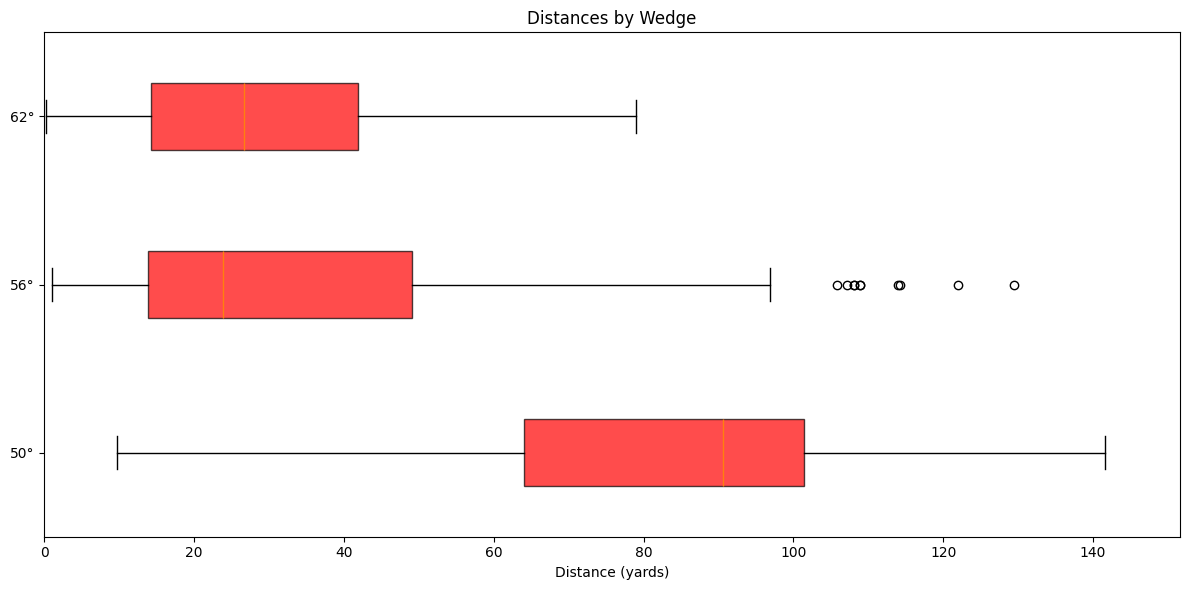

In [233]:
plt.figure(figsize=(12, 6))

# Iterate through each club to plot boxplots next to each other
for i, wedge in enumerate(WEDGES_DESC):
    strokes_for_wedge = strokes_df[strokes_df['club'] == wedge]  # Filter strokes by club
    plt.boxplot(strokes_for_wedge['distance'], vert=False, patch_artist=True, 
                boxprops=dict(facecolor='red', alpha=0.7, color='black', linewidth=1),  # Thicker boxes' edges
                whiskerprops=dict(color='black', linewidth=1),
                capprops=dict(color='black', linewidth=1),
                positions=[i], widths=0.4)  # Adjust width to make boxes thicker

# Customize the plot
plt.title('Distances by Wedge')
plt.xlabel('Distance (yards)')
plt.yticks(range(len(WEDGES_DESC)), WEDGES_DESC)  # Label clubs on the y-axis
plt.xlim(0, strokes_df[strokes_df['club'] == '50°']['distance'].max() + 10)  # Adjust x-axis to fit data

# Show the plot
plt.tight_layout()
plt.show()


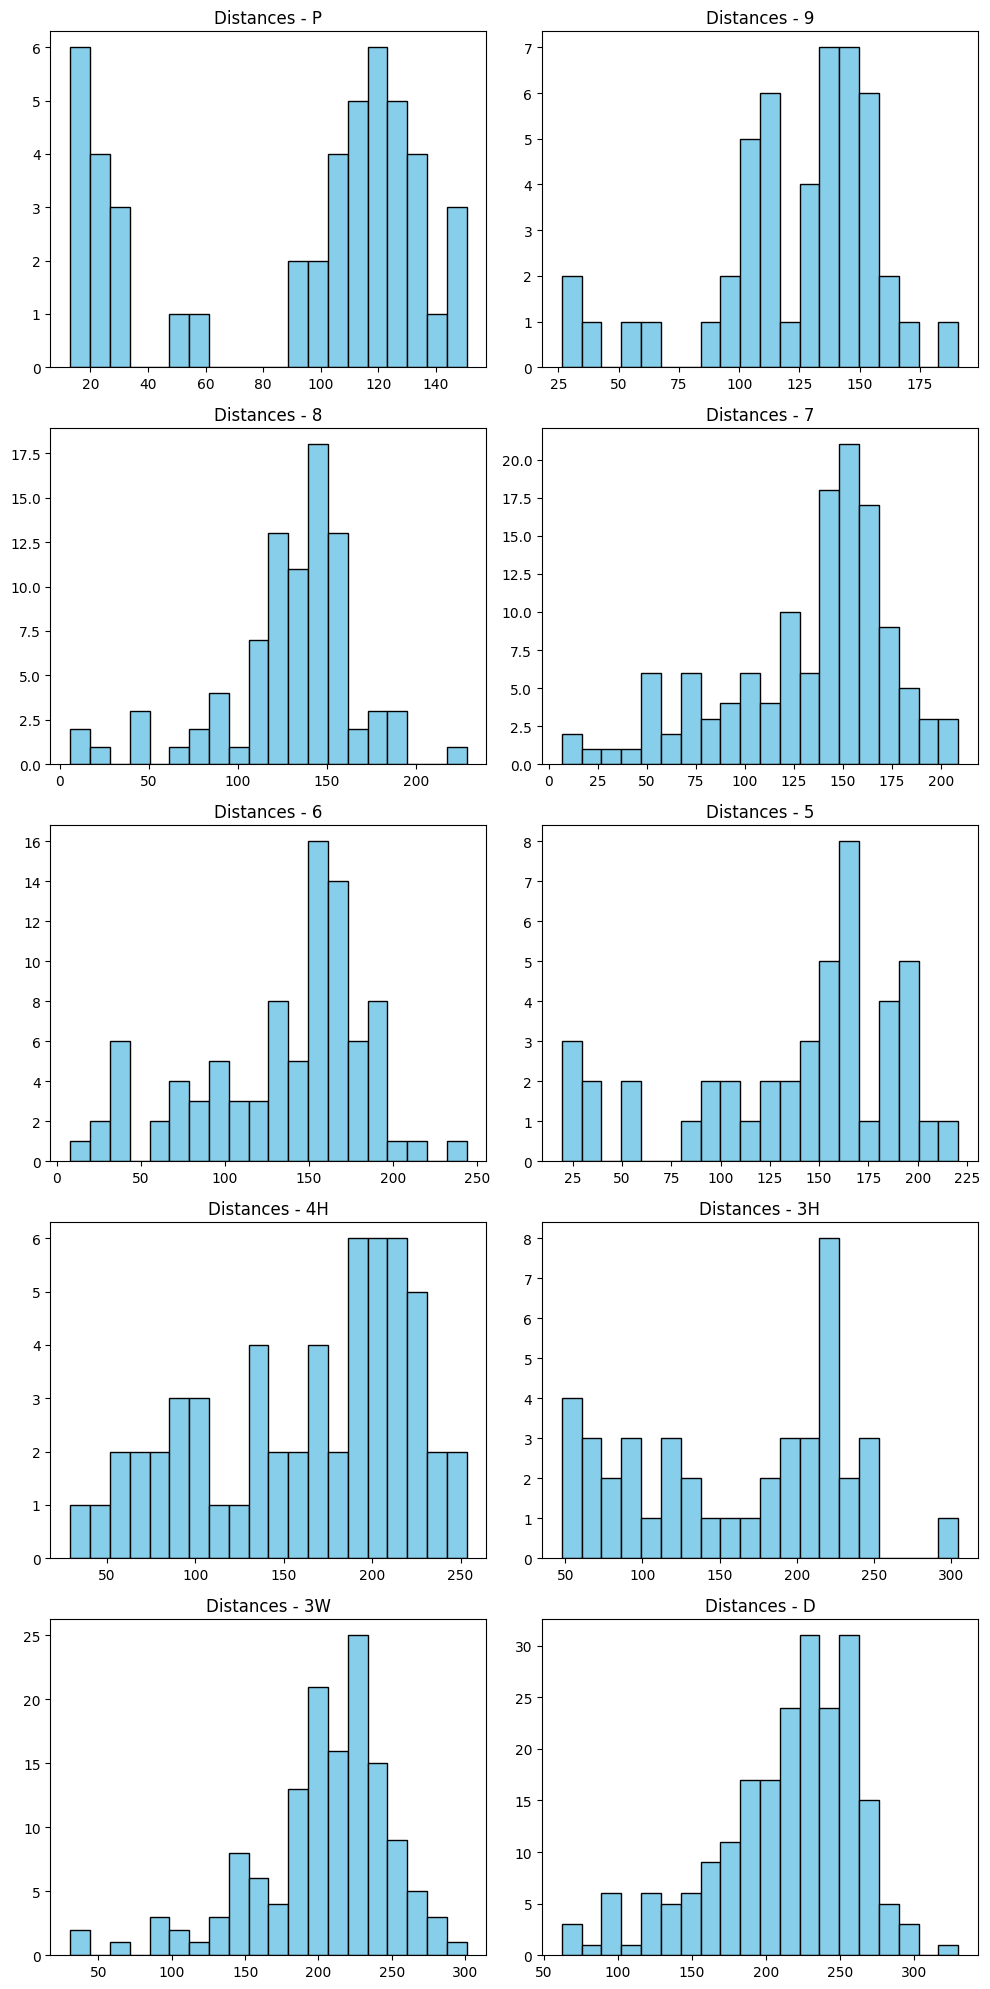

In [234]:
# Plot other club histograms
fig, axs = plt.subplots(5, 2, figsize=(10, 20), tight_layout=True)
for i, club in enumerate(CLUBS_ASC):
    strokes_for_club = strokes_df.where(strokes_df['club'] == club)
    axs[i // 2][i % 2].hist(x = strokes_for_club[['distance']], edgecolor='black', color='skyblue', bins=20)
    axs[i // 2][i % 2].set_title(f'Distances - {club}')

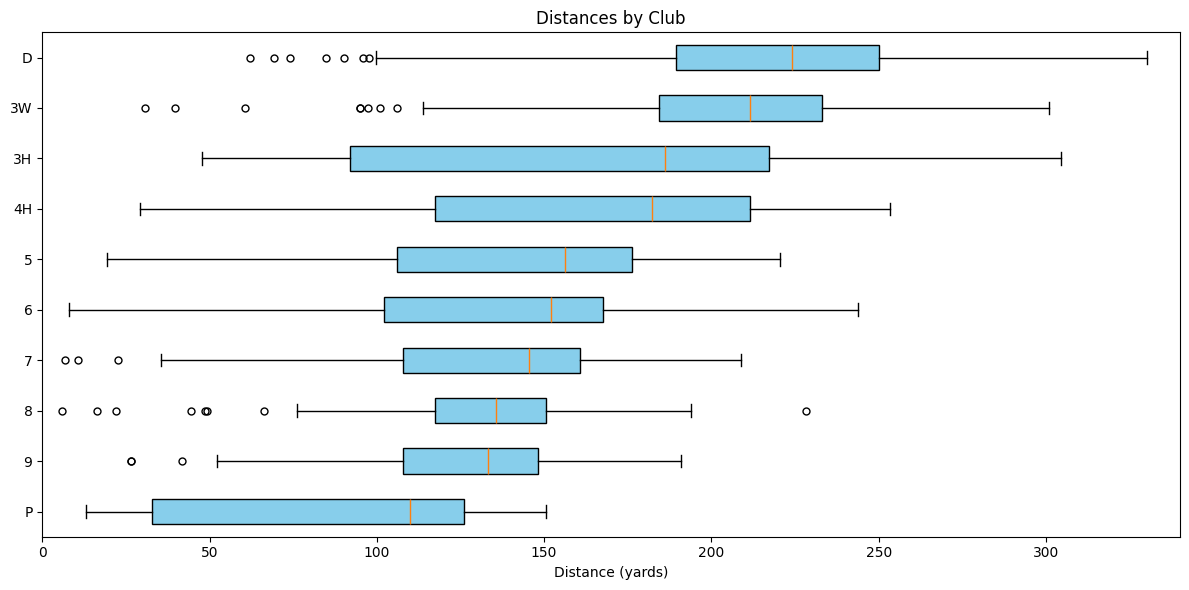

In [235]:
plt.figure(figsize=(12, 6))

# Iterate through each club to plot boxplots next to each other
for i, club in enumerate(CLUBS_ASC):
    strokes_for_club = strokes_df[strokes_df['club'] == club]  # Filter strokes by club
    plt.boxplot(strokes_for_club['distance'], vert=False, patch_artist=True, 
                boxprops=dict(facecolor='skyblue', color='black', linewidth=1),  # Thicker boxes' edges
                whiskerprops=dict(color='black', linewidth=1),
                capprops=dict(color='black', linewidth=1),
                flierprops=dict(marker='o', color='red', markersize=5, linewidth=1),
                positions=[i], widths=0.5)  # Adjust width to make boxes thicker

# Customize the plot
plt.title('Distances by Club')
plt.xlabel('Distance (yards)')
plt.yticks(range(len(CLUBS_ASC)), CLUBS_ASC)  # Label clubs on the y-axis
plt.xlim(0, strokes_df['distance'].max() + 10)  # Adjust x-axis to fit data

# Show the plot
plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'Probability of Hitting Green with Each Club')

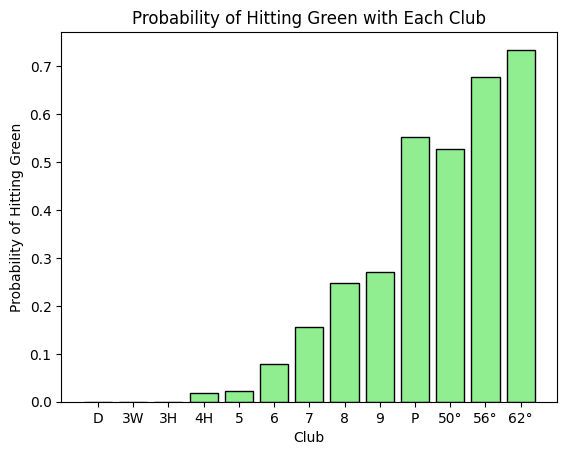

In [236]:
# Likelihood of hitting green with each club
club_strokes_with_hit_green = strokes_df[(strokes_df['hit_green'] == True) & (strokes_df['club'] != 'Club')]
club_strokes_with_hit_green_by_club = club_strokes_with_hit_green.groupby('club')

strokes_by_club = strokes_df[strokes_df['club'] != 'Club'].groupby('club')

hit_green_percentages_by_club = club_strokes_with_hit_green_by_club.size() / strokes_by_club.size()
hit_green_percentages_by_club = hit_green_percentages_by_club.reindex(ALL_CLUBS_DESC)
hit_green_percentages_by_club.fillna(0, inplace=True)

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.bar(hit_green_percentages_by_club.index, hit_green_percentages_by_club, color='lightgreen', edgecolor='black')
ax.set_xlabel('Club')
ax.set_ylabel('Probability of Hitting Green')
ax.set_title('Probability of Hitting Green with Each Club')

#### On Probability of Hitting Green with Each Club Metrics

It's important to be careful with analyzing this metric - it might be tempting to think of the goal with every shot to be to hit the green, but this is not always the case. For example: second shots on Par 5's (first approach shot of the hole) usually have the goal of getting within reach for a manageable 3rd shot - going for the green is a rarity. The same logic applies to long par 4's. So while that shot may count as a 'missed' green, the intention may still be correct.

In [270]:
strokes_with_green_yardages = strokes_df.copy(deep=True)
strokes_with_green_yardages = strokes_with_green_yardages.merge(holes, how='inner', left_on='hole_id', right_on='id')
strokes_with_green_yardages['center_green_point'] = strokes_with_green_yardages['center_green_point'].astype('str').apply(parse_coordinates_with_parentheses)

def distance_to_green(row):
    if row['start_coordinate'] is None or row['center_green_point'] is None:
        return 0
    
    return get_distance_between_points_yards(
        row['start_coordinate'][0], row['start_coordinate'][1],
        row['center_green_point'][0], row['center_green_point'][1]
    )
strokes_with_green_yardages['dist_to_green'] = strokes_with_green_yardages.apply(distance_to_green, axis=1)

strokes_with_green_yardages.head()

,id_x,club,start_coordinate,end_coordinate,stroke_number,hole_id,rnd_id,penalty,penalty_result,hit_green,distance,hit_green_putt_dist,id_y,hole_number,nickname,par,bound_points,center_green_point,course_id,dist_to_green
0,123,8,"[39.91568444815508, -86.04792058467865]","[39.91692031566155, -86.04923497275416]",1,14,11,0,False,False,193.944276,NaN,14,14,None,3,"[[39.915445680919575, -86.04772617176627], [39...","[39.916737836316024, -86.04879751542728]",1,151.980823
1,124,56°,"[39.91692031566155, -86.04923497275416]","[39.91668836719707, -86.04884594678879]",2,14,11,0,False,True,45.957117,11.0,14,14,None,3,"[[39.915445680919575, -86.04772617176627], [39...","[39.916737836316024, -86.04879751542728]",1,46.444422
2,175,D,"[39.916241359532044, -86.05197742581367]","[39.91607686293417, -86.05331718921661]",1,1,11,0,False,False,126.548366,NaN,1,1,None,4,"[[39.91640678790566, -86.05155433250354], [39....","[39.91607953088409, -86.05546979935548]",1,326.321511
3,176,7,"[39.91607686293417, -86.05331718921661]","[39.9160820059701, -86.05466902256012]",2,1,11,0,False,False,126.084840,NaN,1,1,None,4,"[[39.91640678790566, -86.05155433250354], [39....","[39.91607953088409, -86.05546979935548]",1,200.770700
4,177,56°,"[39.9160820059701, -86.05466902256012]","[39.916056547938545, -86.05553671717644]",3,1,11,0,False,True,80.987663,10.0,1,1,None,4,"[[39.91640678790566, -86.05155433250354], [39....","[39.91607953088409, -86.05546979935548]",1,74.687750


Text(0.5, 0, 'Approximate Range (Yards)')

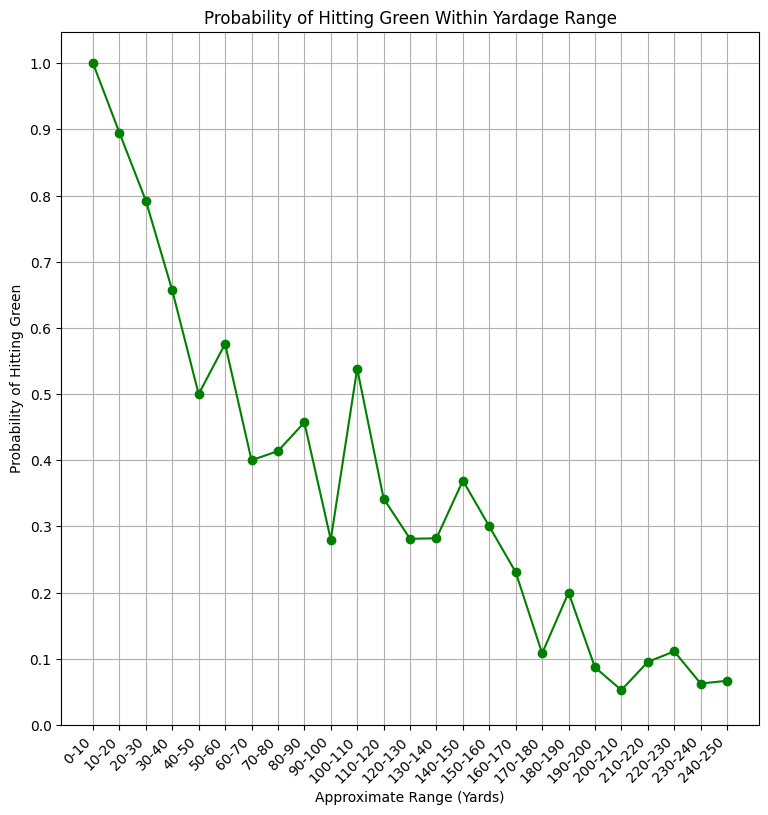

In [271]:
probs = []
labels = []
for y in range(25):
    lower = y * 10
    upper = (y + 1) * 10
    all_strokes_within_range = strokes_with_green_yardages[(strokes_with_green_yardages['dist_to_green'] > lower) & (strokes_with_green_yardages['dist_to_green'] <= upper)]
    strokes_with_range_hit_green = all_strokes_within_range[all_strokes_within_range['hit_green'] == True]
    num_strokes_within_range = len(all_strokes_within_range)
    num_strokes_within_range_hit_green = len(strokes_with_range_hit_green)
    probs.append(num_strokes_within_range_hit_green / num_strokes_within_range)
    labels.append(f"{lower}-{upper}")  # Create labels for x-ticks
fig = plt.figure(figsize=(9, 9))
ax = fig.add_subplot(1, 1, 1)
ax.plot(probs, color='green', marker='o')
ax.grid(True)
ax.set_yticks(np.arange(0, 1.1, step=0.1))
ax.set_ylabel('Probability of Hitting Green')
ax.set_title('Probability of Hitting Green Within Yardage Range')
ax.set_xticks(range(len(labels)))  # Position ticks at the indices
ax.set_xticklabels(labels, rotation=45, ha='right')
ax.set_xlabel('Approximate Range (Yards)')

Text(0.5, 0, 'Approximate Range From Green (Yards)')

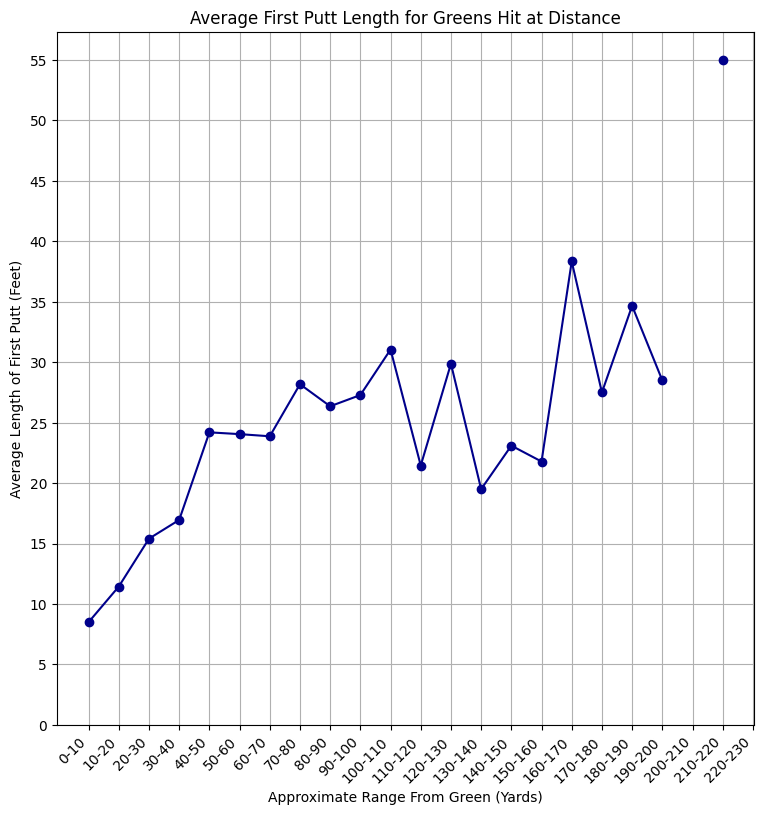

In [285]:
putt_distances = []
labels = []
for y in range(23):
    lower = y * 10
    upper = (y + 1) * 10
    all_strokes_within_range = strokes_with_green_yardages[(strokes_with_green_yardages['dist_to_green'] > lower) & (strokes_with_green_yardages['dist_to_green'] <= upper)]
    strokes_with_range_hit_green = all_strokes_within_range[all_strokes_within_range['hit_green'] == True]
    num_strokes_within_range = len(all_strokes_within_range)
    average_putt_from_hit_green_within_range = all_strokes_within_range['hit_green_putt_dist'].mean()
    putt_distances.append(average_putt_from_hit_green_within_range)
    labels.append(f"{lower}-{upper}")  # Create labels for x-ticks
fig = plt.figure(figsize=(9, 9))
ax = fig.add_subplot(1, 1, 1)
ax.plot(putt_distances, color='darkblue', marker='o')
ax.grid(True)
ax.set_yticks(np.arange(0, max(putt_distances) + 5, step=5))
ax.set_ylabel('Average Length of First Putt (Feet)')
ax.set_title('Average First Putt Length for Greens Hit at Distance')
ax.set_xticks(range(len(labels)))  # Position ticks at the indices
ax.set_xticklabels(labels, rotation=45, ha='right')
ax.set_xlabel('Approximate Range From Green (Yards)')

# Section 2: Penalties

In [293]:
# Display basic penalty statistics
display(strokes_df.head()
penalty_strokes = strokes_df[strokes_df['penalty_result'] == True]

print(f'Total # of strokes taken: {len(strokes_df)}')
print(f'Total # of strokes that resulted in a penalty: {len(penalty_strokes)}')
print(f'% of strokes that result in a penalty: {(len(penalty_strokes) / len(strokes_df) * 100):.2f}%')

,id,club,start_coordinate,end_coordinate,stroke_number,hole_id,rnd_id,penalty,penalty_result,hit_green,distance,hit_green_putt_dist
0,123,8,"[39.91568444815508, -86.04792058467865]","[39.91692031566155, -86.04923497275416]",1,14,11,0,False,False,193.944276,NaN
1,124,56°,"[39.91692031566155, -86.04923497275416]","[39.91668836719707, -86.04884594678879]",2,14,11,0,False,True,45.957117,11.0
2,175,D,"[39.916241359532044, -86.05197742581367]","[39.91607686293417, -86.05331718921661]",1,1,11,0,False,False,126.548366,NaN
3,176,7,"[39.91607686293417, -86.05331718921661]","[39.9160820059701, -86.05466902256012]",2,1,11,0,False,False,126.084840,NaN
4,177,56°,"[39.9160820059701, -86.05466902256012]","[39.916056547938545, -86.05553671717644]",3,1,11,0,False,True,80.987663,10.0


Total # of strokes taken: 1470
Total # of strokes that resulted in a penalty: 0
% of strokes that result in a penalty: 0.00%


In [ ]:
penalties_by_club = penalty_strokes.groupby('club')
all_strokes_by_club = new_strokes.groupby('club')

penalty_percentages_by_club = penalties_by_club.size() / all_strokes_by_club.size()
penalty_percentages_by_club = penalty_percentages_by_club.reindex(clubs_desc)
penalty_percentages_by_club.fillna(0, inplace=True)

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.bar(penalty_percentages_by_club.index, penalty_percentages_by_club, color='darkred', edgecolor='black')
ax.set_xlabel('Club')
ax.set_ylabel('Probablity of Shot Resulting in Penalty')
ax.set_title('Probability of Shot Resulting in Penalty with Each Club')

In [ ]:
# Penalties by Course (How many per course, average # per round at course)

In [ ]:
# Penalties by Club

# Section 4: Tee Shots

In [294]:
# Create DataFrame for tee shots
tee_strokes = strokes_df[strokes_df['stroke_number'] == 1]

In [296]:
# Group tee shots and show basic use stats
tee_strokes_by_club = tee_strokes.groupby('club')

tee_strokes_by_club_count = tee_strokes_by_club.size()
tee_strokes_by_club_count = tee_strokes_by_club_count.reindex(ALL_CLUBS_DESC)

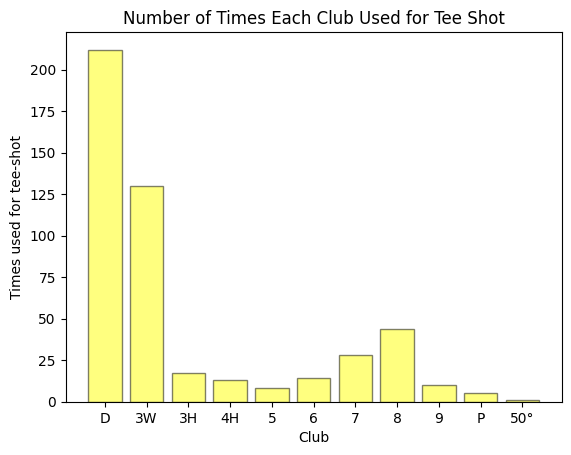

In [302]:
# Plot basic tee-shot statistics
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.bar(tee_strokes_by_club_count.index, tee_strokes_by_club_count, color='yellow', alpha=0.5, edgecolor='black')
ax.set_xlabel('Club')
ax.set_ylabel('Times used for tee-shot')
ax.set_title('Number of Times Each Club Used for Tee Shot')
plt.show()

In [304]:
# Load and merge stats for holes
tee_strokes = tee_strokes.merge(holestats_df, how='inner', left_on=['rnd_id', 'hole_id'], right_on=['rnd_id', 'hole_id'])

In [305]:
tee_shots_with_gld = tee_strokes[tee_strokes['gld'] == 1]
tee_shots_with_gld_by_club = tee_shots_with_gld.groupby('club')
tee_shots_by_club = tee_strokes.groupby('club')
gld_percentages = tee_shots_with_gld_by_club.size() / tee_shots_by_club.size()
gld_percentages.reindex(clubs_desc)
print(gld_percentages)

KeyError: 'gld'

# Section 3: Round Statistics

In [ ]:
# Scatterplots - tee slope/rating vs. round score

# Regression line slope/intercepts for each course/tee played

In [ ]:
# GLD Summary

In [ ]:
# Scrambling Summary

In [ ]:
# Hole score breakdown
# Average score on par 3/4/5
# 

# Section 4: Putting

In [ ]:
# Putting summary

In [ ]:
# Putting Histogram

In [ ]:
# % likelihood to make for discrete distances

# Section 5: Course Statistics

# Section 6: Other fun things